# Analyze Tweets

In [1]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

In [2]:
src = '../data'
hashtags = ['WissZeitVG', 'FristIstFrust', '95vsWissZeitVG', 'IchBinHannah']

In [83]:
def get_tweet_frequency(src, filename, date_cutoff=pd.to_datetime('2018-01-01')):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)
    print('{}: {} Tweets'.format(filename, len(data)))
    data['created_at'] = pd.to_datetime(data['created_at'])
    data['created_at_date'] = data['created_at'].dt.date
    data = data[data['created_at_date'] >= date_cutoff]
    
    frequency = data[['created_at_date', 'id']]\
        .groupby('created_at_date')\
        .agg('count')\
        .rename(columns={'id':'tweet_count'})
    
    return frequency

## Tweets

In [89]:
frequency = get_tweet_frequency(src, '95vsWissZeitVG')
frequency.loc[frequency['tweet_count'].idxmax()]

95vsWissZeitVG: 13827 Tweets


In [92]:
frequency = get_tweet_frequency(src, 'IchBinHannah')
frequency.loc[frequency['tweet_count'].idxmax()]

IchBinHannah: 22001 Tweets


tweet_count    10211
Name: 2021-06-11, dtype: int64

### Hashtag tweet frequency

WissZeitVG: 9802 Tweets
FristIstFrust: 15682 Tweets
95vsWissZeitVG: 13827 Tweets
IchBinHannah: 22001 Tweets


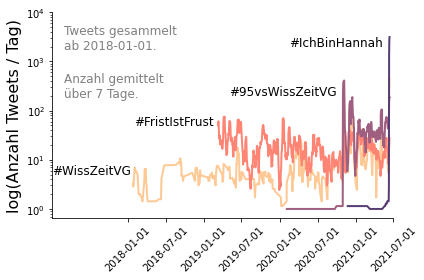

In [84]:
colors = ['#ffc996', '#ff8474', '#9f5f80', '#583d72']

fig, ax = plt.subplots()
for ht, color in zip(hashtags, colors):
    frequency = get_tweet_frequency(src, ht)
    frequency_avg = frequency['tweet_count'].rolling(7).mean().dropna()
    ax.plot(frequency_avg.index, frequency_avg.values, color=color,
            label='#{}'.format(ht), linewidth=2)
    
ax.set_yscale('log')
ax.set_xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2021-07-01'))
ax.set_ylim(ymax=1e4)
ax.set_xticks([pd.to_datetime(t) for t in ['2018-01-01', '2018-07-01',
            '2019-01-01', '2019-07-01','2020-01-01', '2020-07-01',
            '2021-01-01', '2021-07-01',]])
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('log(Anzahl Tweets / Tag)', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(pd.to_datetime('2017-01-01'), 5, '#WissZeitVG', fontsize=12)
ax.text(pd.to_datetime('2018-02-01'), 50, '#FristIstFrust', fontsize=12)
ax.text(pd.to_datetime('2019-05-01'), 210, '#95vsWissZeitVG', fontsize=12)
ax.text(pd.to_datetime('2020-02-15'), 2000, '#IchBinHannah', fontsize=12)

ax.text(pd.to_datetime('2017-03-01'), 1.8*1e3,'Tweets gesammelt\nab 2018-01-01.',
       fontsize=12, color='grey')
ax.text(pd.to_datetime('2017-03-01'), 1.9*1e2,'Anzahl gemittelt\nüber 7 Tage.',
       fontsize=12, color='grey')

fig.tight_layout()
plt.savefig('../plots/tweet_frequency.png', dpi=300)

### Tweets with the video link

In [5]:
frequency = get_tweet_frequency(src, 'video_url')
frequency

,tweet_count
created_at_date,
2021-06-09,28
2021-06-10,859
2021-06-11,488
2021-06-12,56


## Users

### Unique Users

In [80]:
def get_N_authors(src, filename):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)\
        .dropna(subset=['author_id'])
    data['author_id'] = data['author_id'].astype(int)
    N_authors = data['author_id'].unique()
    return len(N_authors)

In [81]:
N_authors = [get_N_authors(src, ht) for ht in hashtags]
N_authors = pd.DataFrame({'hashtag':['#{}'.format(h) for h in hashtags],
                          'N_authors':N_authors})\
    .sort_values(by='N_authors')

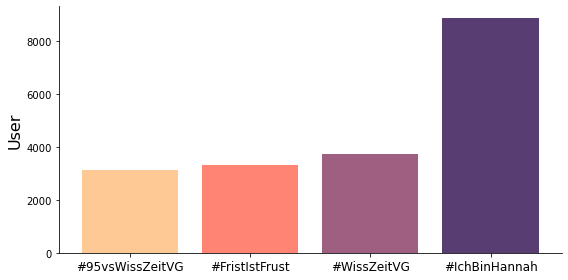

In [91]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(N_authors['hashtag'], N_authors['N_authors'], color=colors)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('User', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
fig.tight_layout()
plt.savefig('../plots/unique_users.png', dpi=300)

### New users for #IchBinHannah

In [31]:
users_95WissZeitVG = set(pd.read_csv(join(src, '{}.csv'.format('95vsWissZeitVG')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())
users_FristIstFrust = set(pd.read_csv(join(src, '{}.csv'.format('FristIstFrust')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())
users_WissZeitVG = set(pd.read_csv(join(src, '{}.csv'.format('WissZeitVG')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())
users_IchBinHannah = set(pd.read_csv(join(src, '{}.csv'.format('IchBinHannah')), 
                        low_memory=False).dropna(subset=['author_id'])['author_id'].unique())

In [32]:
old_users = users_95WissZeitVG.union(users_FristIstFrust).union(users_WissZeitVG)

In [36]:
shared_users = users_IchBinHannah.intersection(old_users)
new_users = users_IchBinHannah - old_users

In [39]:
print('The #IchBinHannah campaign engaged {} new users'.format(len(new_users)))

The #IchBinHannah campaign engaged 5791 new users


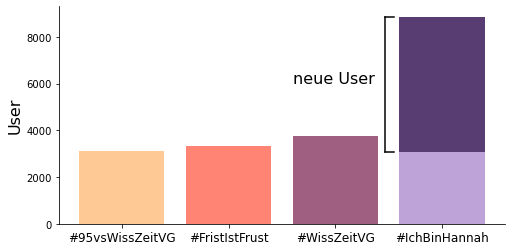

In [79]:
fig, ax = plt.subplots(figsize=(8, 4))
colors_mod = ['#ffc996', '#ff8474', '#9f5f80', '#BEA3D8']
N_old_users = [0, 0, 0, len(shared_users)]

N_authors['new_users'] = list(N_authors.iloc[0:3]['N_authors']) + \
        [len(users_IchBinHannah) - len(shared_users)]
ax.bar(N_authors['hashtag'], N_old_users, color=colors_mod)
ax.bar(N_authors['hashtag'], N_authors['new_users'], 
       bottom=N_old_users, color=colors)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('User', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.plot([2.47, 2.55], [len(shared_users), len(shared_users)], color='k')
ax.plot([2.47, 2.55], [len(users_IchBinHannah), len(users_IchBinHannah)], color='k')
ax.plot([2.47, 2.47], [len(shared_users), len(users_IchBinHannah)], color='k')
ax.text(1.6, 6000, 'neue User', fontsize=16)
plt.savefig('../plots/unique_users_new_users.png', dpi=300)